<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/tabular_playground_series_2021_aug_tabular_playground_series_aug_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import scipy
from scipy.stats import skew

In [2]:
train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_test.csv')
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_sample_submission.csv')
train.shape, test.shape, submit.shape

((250000, 102), (150000, 101), (150000, 2))

In [ ]:
train['loss'].skew()  # target 라벨에 log1p씌울까 

1.4653191365369271

Text(0.5, 1.0, 'Train set Skew')

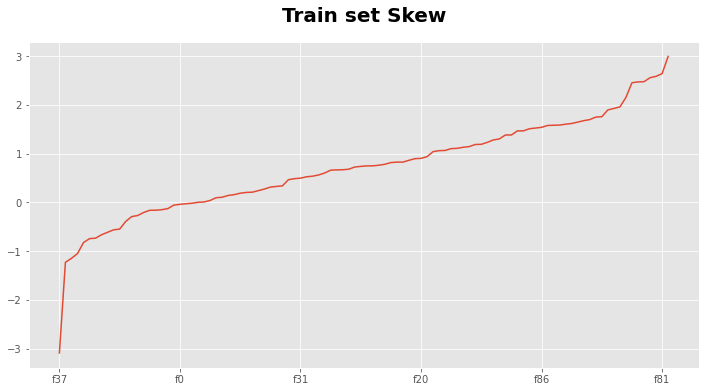

In [ ]:
plt.figure(figsize=(12,6))
train.skew().sort_values().plot()
plt.title('Train set Skew', fontsize=20, fontweight='bold', pad=20)
# noramlize를 적용 할까 고민

# cluster DBSCAN기법

- DBSCAN(density-based spatial clustering of application with noise)은 클러스터의 갯수를 미리 지정하지 않는 군집 알고리즘


- DBSCAN은 병합 군집이나 k-평균보다는 다소 느리지만 비교적 큰 데이터셋에도 적용



- 데이터의 밀집지역이 한 클러스터를 구성하며 비교적 비어있는 지역을 경계로 다른 클러스터와 구분함



- DBSCAN은 특성 공간에서 가까이 있는 데이터가 많아 붐비는 지역의 포인트를 찾음

- 이런 지역을 밀집 지역dense region이라 함

- 밀집 지역에 있는 포인트를 핵심 포인트core point라고함



- 핵심 포인트: min_samples, epsepsilon

  - 한 데이터 포인트에서 eps 거리 안에 데이터가 min_samples 갯수만큼 들어 있으면 이 데이터 포인트를 핵심 포인트로 분류

  - eps(거리)보다 가까운 핵심 샘플은 동일한 클러스터로 분류

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data = pd.concat([train.drop(columns=['id']), test.drop(columns=['id'])], axis=0)
data_columns = data.columns

for i in data.columns:
  if i == 'loss':
    continue
  data[i] = MinMaxScaler().fit_transform(data[[i]])

In [ ]:
from sklearn.cluster import DBSCAN

data['cluster'] = DBSCAN(n_jobs=-1).fit_predict(data.drop(columns=['loss']))
data

KeyboardInterrupt: ignored

# Clustering 적용하자

In [3]:
!pip install catboost
!pip install optuna

     |████████████████████████████████| 67.4 MB 45 kB/s 
     |████████████████████████████████| 302 kB 8.0 MB/s 
     |████████████████████████████████| 164 kB 76.2 MB/s 
     |████████████████████████████████| 80 kB 10.9 MB/s 
     |████████████████████████████████| 75 kB 6.3 MB/s 
     |████████████████████████████████| 141 kB 69.7 MB/s 
     |████████████████████████████████| 111 kB 67.6 MB/s 
     |████████████████████████████████| 49 kB 8.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=5d21dc2d83309daf5699ac65057451baccfc3ef7b223f8a0151c43de603e50c3
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [4]:
import catboost
import optuna
import optuna.integration.lightgbm as lgbo
import lightgbm
import xgboost
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneGroupOut, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [5]:
# 데이터 나누기
x_train = train.drop(columns=['id', 'loss'])
y_train = train['loss']
x_test = test.drop(columns=['id'])
x_train_columns = x_train.columns
x_test_columns = x_test.columns
x_train.shape, y_train.shape, x_test.shape

((250000, 100), (250000,), (150000, 100))

In [6]:
mm = MinMaxScaler().fit(x_train)
x_train = mm.transform(x_train)
x_test = mm.transform(x_test)

x_train = pd.DataFrame(x_train, columns=x_train_columns)
x_test = pd.DataFrame(x_test, columns=x_test_columns)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'elbow method')

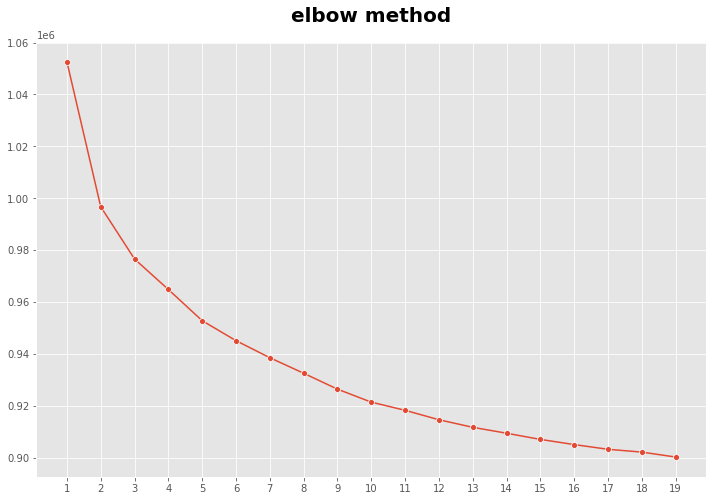

In [ ]:
# Clustering
from sklearn.cluster import KMeans

vstack = np.vstack((x_train,
                    x_test))

sse = {}
for i in range(1,20, 1):
  km = KMeans(n_clusters=i, max_iter=1000, random_state=0, n_jobs=-1).fit(vstack)
  sse[i] = km.inertia_

plt.figure(figsize=(12,8))
sns.lineplot(pd.Series(sse).index, pd.Series(sse), marker='o')
plt.xticks(pd.Series(sse).index)
plt.title('elbow method', fontsize=20, fontweight='bold', pad=20)

In [ ]:
km = KMeans(n_splits=, max_iter=1000, n_jobs=-1).fit(vstack)

x_train['cluster'] = km.predict(x_train)
x_test['cluster'] = km.predict(x_test)

In [ ]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))

for i, (train_index, valid_index) in enumerate(kf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostRegressor(iterations=3000, learning_rate=0.022, loss_function='RMSE', eval_metric='RMSE', task_type='GPU')
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)

  preds += np.expm1(model_cat.predict(x_test)) / kf.n_splits

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 1.1039045	test: 1.1063753	best: 1.1063753 (0)	total: 10.3ms	remaining: 30.9s
100:	learn: 1.0945647	test: 1.0977858	best: 1.0977858 (100)	total: 1.8s	remaining: 51.6s
200:	learn: 1.0901819	test: 1.0942911	best: 1.0942911 (200)	total: 2.91s	remaining: 40.6s
300:	learn: 1.0869794	test: 1.0920953	best: 1.0920953 (300)	total: 4.21s	remaining: 37.7s
400:	learn: 1.0843921	test: 1.0905177	best: 1.0905177 (400)	total: 5.58s	remaining: 36.2s
500:	learn: 1.0821666	test: 1.0893155	best: 1.0893155 (500)	total: 7.41s	remaining: 37s
600:	learn: 1.0800835	test: 1.0882926	best: 1.0882926 (600)	total: 9.82s	remaining: 39.2s
700:	learn: 1.0781490	test: 1.0874149	best: 1.0874149 (700)	total: 12.1s	remaining: 39.7s
800:	learn: 1.0763697	test: 1.0866818	best: 1.0866818 (800)	total: 14.4s	remaining: 39.6s
900:	learn: 1.0746677	test: 1.0860741	best: 1.0860741 (900)	total: 16.9s	remaining: 39.3s
1000:	learn: 1.0730308	test: 1.0855342	best: 1.0855342 (1000)	total: 18.9s	remaining: 37.8s
1100:	learn: 1

# LGBM LB: 7.90478

In [7]:
params = {'objective':'poisson', 'metric': 'rmse' } #'objective': 'mean_squared_error',
from sklearn.metrics import mean_absolute_error
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=42)
lgb_train = lightgbm.Dataset(X_train, Y_train)
lgb_valid = lightgbm.Dataset(X_test, Y_test)
model = lgbo.train(params, lgb_train, valid_sets=[lgb_valid], verbose_eval=False, num_boost_round=100, early_stopping_rounds=5) 
model.params

[I 2021-08-20 04:08:18,123] A new study created in memory with name: no-name-3babc528-ca3d-4ad7-8c80-49faef0015a1
min_data_in_leaf, val_score: 7.871026: 100%|##########| 5/5 [00:54<00:00, 10.98s/it]


{'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'feature_fraction': 0.5,
 'feature_pre_filter': False,
 'lambda_l1': 0.004413706569480422,
 'lambda_l2': 9.534763631167645e-05,
 'metric': 'rmse',
 'min_child_samples': 50,
 'num_leaves': 82,
 'objective': 'poisson'}

In [8]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))
best_lgb_params = model.params
best_lgb_params["learning_rate"] = 0.006
best_lgb_params["num_iterations"] = 10000

for i, (train_index, valid_index) in enumerate(kf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_lgb = lightgbm.LGBMRegressor(**best_lgb_params)
  model_lgb.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)], verbose=100, early_stopping_rounds=70)

  preds += model_lgb.predict(x_test) / kf.n_splits
  val_preds = model_lgb.predict(X_valid)
  RMSE = np.sqrt(mean_squared_error(val_preds, Y_valid))
  print(f'{i+1}번째 RMSE:{RMSE}')

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Training until validation scores don't improve for 70 rounds.
[100]	training's rmse: 7.92044	valid_1's rmse: 7.90716
[200]	training's rmse: 7.898	valid_1's rmse: 7.8974
[300]	training's rmse: 7.87728	valid_1's rmse: 7.88949
[400]	training's rmse: 7.85811	valid_1's rmse: 7.88296
[500]	training's rmse: 7.83967	valid_1's rmse: 7.87724
[600]	training's rmse: 7.82188	valid_1's rmse: 7.87237
[700]	training's rmse: 7.80461	valid_1's rmse: 7.86794
[800]	training's rmse: 7.78778	valid_1's rmse: 7.86388
[900]	training's rmse: 7.77117	valid_1's rmse: 7.86012
[1000]	training's rmse: 7.75493	valid_1's rmse: 7.85671
[1100]	training's rmse: 7.73895	valid_1's rmse: 7.85364
[1200]	training's rmse: 7.72332	valid_1's rmse: 7.85101
[1300]	training's rmse: 7.70793	valid_1's rmse: 7.84836
[1400]	training's rmse: 7.69261	valid_1's rmse: 7.84583
[1500]	training's rmse: 7.67759	valid_1's rmse: 7.84365
[1600]	training's rmse: 7.66276	valid_1's rmse: 7.84153
[1700]	training's rmse: 7.64803	valid_1's rmse: 7.8395

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Training until validation scores don't improve for 70 rounds.
[100]	training's rmse: 7.90867	valid_1's rmse: 7.95375
[200]	training's rmse: 7.88581	valid_1's rmse: 7.94489
[300]	training's rmse: 7.86488	valid_1's rmse: 7.93767
[400]	training's rmse: 7.84551	valid_1's rmse: 7.9318
[500]	training's rmse: 7.82691	valid_1's rmse: 7.92672
[600]	training's rmse: 7.80905	valid_1's rmse: 7.92237
[700]	training's rmse: 7.79155	valid_1's rmse: 7.91855
[800]	training's rmse: 7.7745	valid_1's rmse: 7.91493
[900]	training's rmse: 7.75782	valid_1's rmse: 7.9116
[1000]	training's rmse: 7.74143	valid_1's rmse: 7.90858
[1100]	training's rmse: 7.72533	valid_1's rmse: 7.90596
[1200]	training's rmse: 7.70952	valid_1's rmse: 7.90362
[1300]	training's rmse: 7.69405	valid_1's rmse: 7.90152
[1400]	training's rmse: 7.67879	valid_1's rmse: 7.8995
[1500]	training's rmse: 7.66368	valid_1's rmse: 7.89761
[1600]	training's rmse: 7.64874	valid_1's rmse: 7.89594
[1700]	training's rmse: 7.63401	valid_1's rmse: 7.89446

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Training until validation scores don't improve for 70 rounds.
[100]	training's rmse: 7.91149	valid_1's rmse: 7.94321
[200]	training's rmse: 7.88918	valid_1's rmse: 7.93323
[300]	training's rmse: 7.86855	valid_1's rmse: 7.92511
[400]	training's rmse: 7.84926	valid_1's rmse: 7.91856
[500]	training's rmse: 7.83078	valid_1's rmse: 7.91275
[600]	training's rmse: 7.81304	valid_1's rmse: 7.90771
[700]	training's rmse: 7.79597	valid_1's rmse: 7.90316
[800]	training's rmse: 7.77926	valid_1's rmse: 7.8992
[900]	training's rmse: 7.76287	valid_1's rmse: 7.89548
[1000]	training's rmse: 7.7468	valid_1's rmse: 7.89221
[1100]	training's rmse: 7.73098	valid_1's rmse: 7.88914
[1200]	training's rmse: 7.71536	valid_1's rmse: 7.88604
[1300]	training's rmse: 7.69992	valid_1's rmse: 7.88328
[1400]	training's rmse: 7.6847	valid_1's rmse: 7.88075
[1500]	training's rmse: 7.66963	valid_1's rmse: 7.878
[1600]	training's rmse: 7.65478	valid_1's rmse: 7.87571
[1700]	training's rmse: 7.64016	valid_1's rmse: 7.87356


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Training until validation scores don't improve for 70 rounds.
[100]	training's rmse: 7.91751	valid_1's rmse: 7.91869
[200]	training's rmse: 7.89489	valid_1's rmse: 7.9091
[300]	training's rmse: 7.87405	valid_1's rmse: 7.90131
[400]	training's rmse: 7.85462	valid_1's rmse: 7.89484
[500]	training's rmse: 7.83601	valid_1's rmse: 7.8894
[600]	training's rmse: 7.81797	valid_1's rmse: 7.88463
[700]	training's rmse: 7.80063	valid_1's rmse: 7.8805
[800]	training's rmse: 7.78351	valid_1's rmse: 7.87678
[900]	training's rmse: 7.76698	valid_1's rmse: 7.87332
[1000]	training's rmse: 7.75071	valid_1's rmse: 7.87014
[1100]	training's rmse: 7.73462	valid_1's rmse: 7.86718
[1200]	training's rmse: 7.71883	valid_1's rmse: 7.86477
[1300]	training's rmse: 7.70332	valid_1's rmse: 7.86245
[1400]	training's rmse: 7.688	valid_1's rmse: 7.86047
[1500]	training's rmse: 7.67294	valid_1's rmse: 7.85844
[1600]	training's rmse: 7.65805	valid_1's rmse: 7.85671
[1700]	training's rmse: 7.64331	valid_1's rmse: 7.85518


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Training until validation scores don't improve for 70 rounds.
[100]	training's rmse: 7.91743	valid_1's rmse: 7.91721
[200]	training's rmse: 7.89475	valid_1's rmse: 7.90752
[300]	training's rmse: 7.87374	valid_1's rmse: 7.89955
[400]	training's rmse: 7.85429	valid_1's rmse: 7.89325
[500]	training's rmse: 7.83568	valid_1's rmse: 7.88788
[600]	training's rmse: 7.81779	valid_1's rmse: 7.88337
[700]	training's rmse: 7.8003	valid_1's rmse: 7.87935
[800]	training's rmse: 7.78329	valid_1's rmse: 7.87572
[900]	training's rmse: 7.76658	valid_1's rmse: 7.87255
[1000]	training's rmse: 7.75025	valid_1's rmse: 7.86943
[1100]	training's rmse: 7.73421	valid_1's rmse: 7.86671
[1200]	training's rmse: 7.71854	valid_1's rmse: 7.8643
[1300]	training's rmse: 7.70309	valid_1's rmse: 7.86186
[1400]	training's rmse: 7.68778	valid_1's rmse: 7.85973
[1500]	training's rmse: 7.67272	valid_1's rmse: 7.85782
[1600]	training's rmse: 7.65778	valid_1's rmse: 7.85601
[1700]	training's rmse: 7.64304	valid_1's rmse: 7.854

# XGBoost LB: 

In [9]:
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {
        'tweedie_variance_power': trial.suggest_discrete_uniform('tweedie_variance_power', 1.0, 2.0, 0.1),
        'max_depth': trial.suggest_int('max_depth', 4, 12), # Extremely prone to overfitting!
        'n_estimators': trial.suggest_int('n_estimators', 400, 4000, 400), # Extremely prone to overfitting!
        'eta': trial.suggest_float('eta', 0.007, 0.013), # Most important parameter.
        'subsample': trial.suggest_discrete_uniform('subsample', 0.2, 0.9, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.2, 0.9, 0.1),
        'colsample_bylevel': trial.suggest_discrete_uniform('colsample_bylevel', 0.2, 0.9, 0.1),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-4, 1e4), # I've had trouble with LB score until tuning this.
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e4), # L2 regularization
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e4), # L1 regularization
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),
        'objective' : 'reg:tweedie',
        'tree_method' : 'gpu_hist',
        'loss_function':'rmse',
        'eval_metric':'rmse'
     }

    model = xgboost.XGBRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSE = np.sqrt(mean_squared_error(y_test, y_preds))
    
    return RMSE

In [10]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-08-20 05:04:06,967] A new study created in memory with name: no-name-f8f30646-6547-4a0c-982d-2b6be22f47fd
[I 2021-08-20 05:04:12,495] Trial 0 finished with value: 7.990864328624096 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 10, 'n_estimators': 4000, 'eta': 0.00857068244939204, 'subsample': 0.2, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.006564646031225318, 'reg_lambda': 0.003111282411181626, 'reg_alpha': 0.0106427439905003, 'gamma': 9846.767050778637}. Best is trial 0 with value: 7.990864328624096.
[I 2021-08-20 05:04:17,153] Trial 1 finished with value: 7.862799886477931 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 12, 'n_estimators': 1200, 'eta': 0.010701103263660267, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.5, 'min_child_weight': 0.0010482851487745965, 'reg_lambda': 11.399289971855897, 'reg_alpha': 269.3786924247547, 'gamma': 249.30927324393

Number of finished trials: 50
Best trial: score 7.819953496383578, params {'tweedie_variance_power': 2.0, 'max_depth': 5, 'n_estimators': 2000, 'eta': 0.012601157566337806, 'subsample': 0.9, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 11.189273632197649, 'reg_lambda': 2759.9476562104073, 'reg_alpha': 231.67726087505588, 'gamma': 0.0009022875526131941}


In [11]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))
params_xgb = {'objective' : 'reg:tweedie',
          'tree_method' : 'gpu_hist',
          'loss_function':'rmse',
          'eval_metric':'rmse',
          'tweedie_variance_power' : study.best_params['tweedie_variance_power'],
          'max_depth': study.best_params['max_depth'],
          'n_estimators': study.best_params['n_estimators'],
          'eta': study.best_params['eta'],
          'colsample_bytree': study.best_params['colsample_bytree'],
          'colsample_bylevel': study.best_params['colsample_bylevel'],
          'min_child_weight': study.best_params['min_child_weight'],
          'reg_lambda': study.best_params['reg_lambda'],
          'reg_alpha': study.best_params['reg_alpha'],
          'gamma': study.best_params['gamma'],
          'subsample': study.best_params['subsample']
          }

for i, (train_index, valid_index) in enumerate(sk.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_xgb = xgboost.XGBRegressor(**params_xgb)
  model_xgb.fit(X_train, Y_train, eval_set=((X_train, Y_train), (X_valid, Y_valid)), verbose=100, early_stopping_rounds=70)

  preds += model_xgb.predict(x_test) / sk.n_splits
  val_preds = model_xgb.predict(X_valid)
  RMSE = np.sqrt(mean_squared_error(Y_valid, val_preds))
  print(f'{i+1}번째 RMSE:{RMSE}')

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



[0]	validation_0-rmse:10.1147	validation_1-rmse:10.1135
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 70 rounds.
[100]	validation_0-rmse:7.87539	validation_1-rmse:7.89595
[200]	validation_0-rmse:7.82706	validation_1-rmse:7.87158
[300]	validation_0-rmse:7.7966	validation_1-rmse:7.86083
[400]	validation_0-rmse:7.7737	validation_1-rmse:7.8557
[500]	validation_0-rmse:7.75183	validation_1-rmse:7.85347
[600]	validation_0-rmse:7.73341	validation_1-rmse:7.85183
[700]	validation_0-rmse:7.71576	validation_1-rmse:7.85127
[800]	validation_0-rmse:7.69951	validation_1-rmse:7.85116
[900]	validation_0-rmse:7.68222	validation_1-rmse:7.85081
Stopping. Best iteration:
[839]	validation_0-rmse:7.69264	validation_1-rmse:7.85036

1번째 RMSE:7.850355725753489
[0]	validation_0-rmse:10.1141	validation_1-rmse:10.1157
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will

# Catboost LB : 7.87727

In [12]:
cat_features = x_train.select_dtypes('object').columns
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 25000),
             'loss_function':'RMSE',
              'task_type':"GPU",
              'eval_metric':'RMSE',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,13),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Depthwise',
              'objective' : 'Poisson'
               }
    model = catboost.CatBoostRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSE = np.sqrt(mean_squared_error(y_test, y_preds))
    
    return RMSE

In [13]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-08-20 05:09:05,714] A new study created in memory with name: no-name-3dca46c1-9a76-4060-b55f-f64365a0d999
[I 2021-08-20 05:10:12,688] Trial 0 finished with value: 7.864715866064944 and parameters: {'iterations': 3292, 'learning_rate': 0.21799749903200194, 'reg_lambda': 27.1027967293561, 'subsample': 0.0971555881424161, 'random_strength': 37.91169222874759, 'depth': 6, 'min_data_in_leaf': 29, 'leaf_estimation_iterations': 1}. Best is trial 0 with value: 7.864715866064944.
[I 2021-08-20 05:10:22,700] Trial 1 finished with value: 7.948111695478873 and parameters: {'iterations': 2677, 'learning_rate': 0.1548825069537294, 'reg_lambda': 50.17359258613965, 'subsample': 0.9821573842202389, 'random_strength': 39.28505554561299, 'depth': 12, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 14}. Best is trial 0 with value: 7.864715866064944.
[I 2021-08-20 05:10:39,739] Trial 2 finished with value: 7.834023970117182 and parameters: {'iterations': 4536, 'learning_rate': 0.0420595026688

Number of finished trials: 50
Best trial: score 7.816976286716461, params {'iterations': 16775, 'learning_rate': 0.010244030620704555, 'reg_lambda': 80.96802642885474, 'subsample': 0.6390183020165221, 'random_strength': 15.797941455357567, 'depth': 4, 'min_data_in_leaf': 22, 'leaf_estimation_iterations': 5}


In [14]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))
params_cat = {'iterations':study.best_params['iterations'],
         'loss_function':'RMSE',
         'task_type':"GPU",
         'eval_metric':'RMSE',
         'leaf_estimation_method':'Newton',
         'bootstrap_type': 'Bernoulli',
         'learning_rate' : study.best_params['learning_rate'],
         'reg_lambda': study.best_params['reg_lambda'],
         'subsample': study.best_params['subsample'],
         'random_strength': study.best_params['random_strength'],
         'depth': study.best_params['depth'],
         'min_data_in_leaf': study.best_params['min_data_in_leaf'],
         'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
         'grow_policy' : 'Depthwise',  
}

for i, (train_index, valid_index) in enumerate(sk.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostRegressor(**params_cat)
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)

  preds += model_cat.predict(x_test) / sk.n_splits
  val_preds = model_cat.predict(X_valid)
  RMSE = np.sqrt(mean_squared_error(val_preds, Y_valid))
  print(f'{i+1}번째 RMSE:{RMSE}')

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



0:	learn: 7.9400060	test: 7.9389810	best: 7.9389810 (0)	total: 8.93ms	remaining: 2m 29s
100:	learn: 7.9162867	test: 7.9220165	best: 7.9220165 (100)	total: 706ms	remaining: 1m 56s
200:	learn: 7.9009531	test: 7.9127520	best: 7.9127520 (200)	total: 1.43s	remaining: 1m 57s
300:	learn: 7.8880156	test: 7.9057217	best: 7.9057217 (300)	total: 2.15s	remaining: 1m 57s
400:	learn: 7.8765821	test: 7.8996902	best: 7.8996902 (400)	total: 2.86s	remaining: 1m 56s
500:	learn: 7.8661404	test: 7.8944012	best: 7.8944012 (500)	total: 3.6s	remaining: 1m 56s
600:	learn: 7.8567255	test: 7.8896610	best: 7.8896610 (600)	total: 4.34s	remaining: 1m 56s
700:	learn: 7.8478214	test: 7.8856655	best: 7.8856655 (700)	total: 5.08s	remaining: 1m 56s
800:	learn: 7.8391779	test: 7.8817647	best: 7.8817647 (800)	total: 5.81s	remaining: 1m 55s
900:	learn: 7.8310127	test: 7.8783329	best: 7.8783329 (900)	total: 6.55s	remaining: 1m 55s
1000:	learn: 7.8232369	test: 7.8753952	best: 7.8753952 (1000)	total: 7.28s	remaining: 1m 54s
1

# voting regressor

In [15]:
from sklearn.ensemble import VotingRegressor

In [16]:
cat = catboost.CatBoostRegressor(**params_cat)
lgb = lightgbm.LGBMRegressor(**best_lgb_params)
xgb = xgboost.XGBRegressor(**params_xgb)

In [17]:
from sklearn.ensemble import VotingRegressor
folds = KFold(n_splits = 10, random_state = 2021, shuffle = True)

predictions = np.zeros((len(x_test),))

for fold, (trn_idx, val_idx) in enumerate(folds.split(x_train)):
    print(f"Fold: {fold}")
    X_train, X_val = x_train.values[trn_idx], x_train.values[val_idx]
    Y_train, Y_val = y_train.values[trn_idx], y_train.values[val_idx]

    model = VotingRegressor(
            estimators = [
                ('lgbm', lgb),
                ('xgb', xgb),
                ('cat', cat)
            ],
            weights = [0.15, 0.65, 0.2]
        )
   
    model.fit(X_train, Y_train)
    pred = model.predict(X_val)
    error = mean_squared_error(Y_val, pred,squared = False)
    print(f" mean_squared_error: {error}")
    print("-"*50)
    
    predictions += model.predict(x_test) / folds.n_splits 

Fold: 0


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
11778:	learn: 7.4144508	total: 1m 31s	remaining: 39s
11779:	learn: 7.4144268	total: 1m 31s	remaining: 39s
11780:	learn: 7.4143998	total: 1m 31s	remaining: 39s
11781:	learn: 7.4143704	total: 1m 31s	remaining: 39s
11782:	learn: 7.4143387	total: 1m 31s	remaining: 38.9s
11783:	learn: 7.4143012	total: 1m 31s	remaining: 38.9s
11784:	learn: 7.4142727	total: 1m 31s	remaining: 38.9s
11785:	learn: 7.4142463	total: 1m 31s	remaining: 38.9s
11786:	learn: 7.4142200	total: 1m 31s	remaining: 38.9s
11787:	learn: 7.4141918	total: 1m 31s	remaining: 38.9s
11788:	learn: 7.4141600	total: 1m 31s	remaining: 38.9s
11789:	learn: 7.4141295	total: 1m 31s	remaining: 38.9s
11790:	learn: 7.4141028	total: 1m 31s	remaining: 38.9s
11791:	learn: 7.4140644	total: 1m 31s	remaining: 38.9s
11792:	learn: 7.4140362	total: 1m 31s	remaining: 38.9s
11793:	learn: 7.4140060	total: 1m 32s	remaining: 38.9s
11794:	learn: 7.4139751	total: 1m 32s	remaining: 38.9s
11795:	learn: 7.4139505	total: 1m 32s

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
11778:	learn: 7.4180156	total: 1m 31s	remaining: 39s
11779:	learn: 7.4179854	total: 1m 31s	remaining: 39s
11780:	learn: 7.4179524	total: 1m 31s	remaining: 39s
11781:	learn: 7.4179299	total: 1m 32s	remaining: 39s
11782:	learn: 7.4178928	total: 1m 32s	remaining: 39s
11783:	learn: 7.4178682	total: 1m 32s	remaining: 39s
11784:	learn: 7.4178383	total: 1m 32s	remaining: 39s
11785:	learn: 7.4178062	total: 1m 32s	remaining: 39s
11786:	learn: 7.4177804	total: 1m 32s	remaining: 39s
11787:	learn: 7.4177475	total: 1m 32s	remaining: 38.9s
11788:	learn: 7.4177067	total: 1m 32s	remaining: 38.9s
11789:	learn: 7.4176798	total: 1m 32s	remaining: 38.9s
11790:	learn: 7.4176498	total: 1m 32s	remaining: 38.9s
11791:	learn: 7.4176184	total: 1m 32s	remaining: 38.9s
11792:	learn: 7.4175881	total: 1m 32s	remaining: 38.9s
11793:	learn: 7.4175513	total: 1m 32s	remaining: 38.9s
11794:	learn: 7.4175189	total: 1m 32s	remaining: 38.9s
11795:	learn: 7.4174827	total: 1m 32s	remaining

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
11778:	learn: 7.4122838	total: 1m 33s	remaining: 39.7s
11779:	learn: 7.4122595	total: 1m 33s	remaining: 39.7s
11780:	learn: 7.4122322	total: 1m 33s	remaining: 39.7s
11781:	learn: 7.4122017	total: 1m 33s	remaining: 39.7s
11782:	learn: 7.4121621	total: 1m 33s	remaining: 39.7s
11783:	learn: 7.4121285	total: 1m 33s	remaining: 39.7s
11784:	learn: 7.4120979	total: 1m 33s	remaining: 39.7s
11785:	learn: 7.4120667	total: 1m 33s	remaining: 39.7s
11786:	learn: 7.4120398	total: 1m 33s	remaining: 39.7s
11787:	learn: 7.4120110	total: 1m 33s	remaining: 39.7s
11788:	learn: 7.4119723	total: 1m 33s	remaining: 39.6s
11789:	learn: 7.4119372	total: 1m 33s	remaining: 39.6s
11790:	learn: 7.4118997	total: 1m 33s	remaining: 39.6s
11791:	learn: 7.4118659	total: 1m 33s	remaining: 39.6s
11792:	learn: 7.4118374	total: 1m 33s	remaining: 39.6s
11793:	learn: 7.4118047	total: 1m 33s	remaining: 39.6s
11794:	learn: 7.4117906	total: 1m 33s	remaining: 39.6s
11795:	learn: 7.4117642	total

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
11778:	learn: 7.4116647	total: 1m 34s	remaining: 40.2s
11779:	learn: 7.4116299	total: 1m 34s	remaining: 40.2s
11780:	learn: 7.4115999	total: 1m 34s	remaining: 40.1s
11781:	learn: 7.4115660	total: 1m 34s	remaining: 40.1s
11782:	learn: 7.4115391	total: 1m 34s	remaining: 40.1s
11783:	learn: 7.4115115	total: 1m 34s	remaining: 40.1s
11784:	learn: 7.4114818	total: 1m 34s	remaining: 40.1s
11785:	learn: 7.4114482	total: 1m 34s	remaining: 40.1s
11786:	learn: 7.4114098	total: 1m 34s	remaining: 40.1s
11787:	learn: 7.4113780	total: 1m 34s	remaining: 40.1s
11788:	learn: 7.4113514	total: 1m 34s	remaining: 40.1s
11789:	learn: 7.4113082	total: 1m 34s	remaining: 40.1s
11790:	learn: 7.4112794	total: 1m 34s	remaining: 40.1s
11791:	learn: 7.4112377	total: 1m 34s	remaining: 40.1s
11792:	learn: 7.4112149	total: 1m 34s	remaining: 40.1s
11793:	learn: 7.4111840	total: 1m 34s	remaining: 40s
11794:	learn: 7.4111583	total: 1m 34s	remaining: 40s
11795:	learn: 7.4111256	total: 1m

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
11775:	learn: 7.4169191	total: 1m 35s	remaining: 40.4s
11776:	learn: 7.4168873	total: 1m 35s	remaining: 40.4s
11777:	learn: 7.4168562	total: 1m 35s	remaining: 40.4s
11778:	learn: 7.4168211	total: 1m 35s	remaining: 40.4s
11779:	learn: 7.4167924	total: 1m 35s	remaining: 40.3s
11780:	learn: 7.4167561	total: 1m 35s	remaining: 40.3s
11781:	learn: 7.4167243	total: 1m 35s	remaining: 40.3s
11782:	learn: 7.4167019	total: 1m 35s	remaining: 40.3s
11783:	learn: 7.4166716	total: 1m 35s	remaining: 40.3s
11784:	learn: 7.4166339	total: 1m 35s	remaining: 40.3s
11785:	learn: 7.4166069	total: 1m 35s	remaining: 40.3s
11786:	learn: 7.4165760	total: 1m 35s	remaining: 40.3s
11787:	learn: 7.4165383	total: 1m 35s	remaining: 40.3s
11788:	learn: 7.4165023	total: 1m 35s	remaining: 40.3s
11789:	learn: 7.4164751	total: 1m 35s	remaining: 40.3s
11790:	learn: 7.4164523	total: 1m 35s	remaining: 40.3s
11791:	learn: 7.4164196	total: 1m 35s	remaining: 40.3s
11792:	learn: 7.4163807	total

KeyboardInterrupt: ignored

# Stacking Regressor

In [18]:
cat = catboost.CatBoostRegressor(**params_cat)
xgb = xgboost.XGBRegressor(**params_xgb)

In [19]:
from sklearn.ensemble import StackingRegressor

folds = KFold(n_splits = 10, random_state = 2021, shuffle = True)

predictions = np.zeros((len(x_test),))

for fold, (trn_idx, val_idx) in enumerate(folds.split(x_train)):
    print(f"Fold: {fold}")
    X_train, X_val = x_train.values[trn_idx], x_train.values[val_idx]
    Y_train, Y_val = y_train.values[trn_idx], y_train.values[val_idx]

    model = StackingRegressor(
            estimators = [
                ('xgb', xgb),
                ('cat', cat)
            ],
            final_estimator=lightgbm.LGBMRegressor(**best_lgb_params)
        )
   
    model.fit(X_train, Y_train)
    pred = model.predict(X_val)
    error = mean_squared_error(Y_val, pred,squared = False)
    print(f" mean_squared_error: {error}")
    print("-"*50)
    
    predictions += model.predict(x_test) / folds.n_splits 

Streaming output truncated to the last 5000 lines.
11775:	learn: 7.3146983	total: 1m 28s	remaining: 37.6s
11776:	learn: 7.3146527	total: 1m 28s	remaining: 37.6s
11777:	learn: 7.3146030	total: 1m 28s	remaining: 37.6s
11778:	learn: 7.3145658	total: 1m 28s	remaining: 37.6s
11779:	learn: 7.3145293	total: 1m 28s	remaining: 37.6s
11780:	learn: 7.3144818	total: 1m 28s	remaining: 37.5s
11781:	learn: 7.3144537	total: 1m 28s	remaining: 37.5s
11782:	learn: 7.3144104	total: 1m 28s	remaining: 37.5s
11783:	learn: 7.3143645	total: 1m 28s	remaining: 37.5s
11784:	learn: 7.3143204	total: 1m 28s	remaining: 37.5s
11785:	learn: 7.3142919	total: 1m 28s	remaining: 37.5s
11786:	learn: 7.3142464	total: 1m 28s	remaining: 37.5s
11787:	learn: 7.3142057	total: 1m 28s	remaining: 37.5s
11788:	learn: 7.3141632	total: 1m 28s	remaining: 37.5s
11789:	learn: 7.3141298	total: 1m 28s	remaining: 37.5s
11790:	learn: 7.3140922	total: 1m 28s	remaining: 37.5s
11791:	learn: 7.3140603	total: 1m 28s	remaining: 37.5s
11792:	learn: 

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Streaming output truncated to the last 5000 lines.
11775:	learn: 7.3220421	total: 1m 29s	remaining: 37.8s
11776:	learn: 7.3220019	total: 1m 29s	remaining: 37.8s
11777:	learn: 7.3219681	total: 1m 29s	remaining: 37.8s
11778:	learn: 7.3219229	total: 1m 29s	remaining: 37.8s
11779:	learn: 7.3218888	total: 1m 29s	remaining: 37.8s
11780:	learn: 7.3218387	total: 1m 29s	remaining: 37.8s
11781:	learn: 7.3218053	total: 1m 29s	remaining: 37.7s
11782:	learn: 7.3217632	total: 1m 29s	remaining: 37.7s
11783:	learn: 7.3217226	total: 1m 29s	remaining: 37.7s
11784:	learn: 7.3216870	total: 1m 29s	remaining: 37.7s
11785:	learn: 7.3216562	total: 1m 29s	remaining: 37.7s
11786:	learn: 7.3216175	total: 1m 29s	remaining: 37.7s
11787:	learn: 7.3215743	total: 1m 29s	remaining: 37.7s
11788:	learn: 7.3215284	total: 1m 29s	remaining: 37.7s
11789:	learn: 7.3214923	total: 1m 29s	remaining: 37.7s
11790:	learn: 7.3214616	total: 1m 29s	remaining: 37.7s
11791:	learn: 7.3214206	total: 1m 29s	remaining: 37.7s
11792:	learn: 

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Streaming output truncated to the last 5000 lines.
11775:	learn: 7.3158975	total: 1m 29s	remaining: 38s
11776:	learn: 7.3158583	total: 1m 29s	remaining: 38s
11777:	learn: 7.3158211	total: 1m 29s	remaining: 38s
11778:	learn: 7.3157835	total: 1m 29s	remaining: 38s
11779:	learn: 7.3157517	total: 1m 29s	remaining: 38s
11780:	learn: 7.3157198	total: 1m 29s	remaining: 38s
11781:	learn: 7.3156806	total: 1m 29s	remaining: 38s
11782:	learn: 7.3156438	total: 1m 29s	remaining: 38s
11783:	learn: 7.3156005	total: 1m 29s	remaining: 38s
11784:	learn: 7.3155614	total: 1m 29s	remaining: 37.9s
11785:	learn: 7.3155155	total: 1m 29s	remaining: 37.9s
11786:	learn: 7.3154710	total: 1m 29s	remaining: 37.9s
11787:	learn: 7.3154373	total: 1m 29s	remaining: 37.9s
11788:	learn: 7.3153962	total: 1m 29s	remaining: 37.9s
11789:	learn: 7.3153651	total: 1m 29s	remaining: 37.9s
11790:	learn: 7.3153165	total: 1m 29s	remaining: 37.9s
11791:	learn: 7.3152880	total: 1m 29s	remaining: 37.9s
11792:	learn: 7.3152576	total: 1

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Streaming output truncated to the last 5000 lines.
11775:	learn: 7.3167973	total: 1m 30s	remaining: 38.4s
11776:	learn: 7.3167612	total: 1m 30s	remaining: 38.4s
11777:	learn: 7.3167187	total: 1m 30s	remaining: 38.4s
11778:	learn: 7.3166891	total: 1m 30s	remaining: 38.4s
11779:	learn: 7.3166545	total: 1m 30s	remaining: 38.4s
11780:	learn: 7.3166196	total: 1m 30s	remaining: 38.4s
11781:	learn: 7.3165858	total: 1m 30s	remaining: 38.4s
11782:	learn: 7.3165543	total: 1m 30s	remaining: 38.3s
11783:	learn: 7.3165247	total: 1m 30s	remaining: 38.3s
11784:	learn: 7.3164856	total: 1m 30s	remaining: 38.3s
11785:	learn: 7.3164449	total: 1m 30s	remaining: 38.3s
11786:	learn: 7.3164123	total: 1m 30s	remaining: 38.3s
11787:	learn: 7.3163736	total: 1m 30s	remaining: 38.3s
11788:	learn: 7.3163364	total: 1m 30s	remaining: 38.3s
11789:	learn: 7.3163083	total: 1m 30s	remaining: 38.3s
11790:	learn: 7.3162703	total: 1m 30s	remaining: 38.3s
11791:	learn: 7.3162320	total: 1m 30s	remaining: 38.3s
11792:	learn: 

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Streaming output truncated to the last 5000 lines.
11775:	learn: 7.3239694	total: 1m 30s	remaining: 38.5s
11776:	learn: 7.3239250	total: 1m 30s	remaining: 38.5s
11777:	learn: 7.3238856	total: 1m 30s	remaining: 38.5s
11778:	learn: 7.3238533	total: 1m 30s	remaining: 38.5s
11779:	learn: 7.3238078	total: 1m 30s	remaining: 38.5s
11780:	learn: 7.3237669	total: 1m 30s	remaining: 38.5s
11781:	learn: 7.3237229	total: 1m 30s	remaining: 38.5s
11782:	learn: 7.3236846	total: 1m 30s	remaining: 38.5s
11783:	learn: 7.3236406	total: 1m 30s	remaining: 38.5s
11784:	learn: 7.3235958	total: 1m 30s	remaining: 38.5s
11785:	learn: 7.3235533	total: 1m 30s	remaining: 38.4s
11786:	learn: 7.3235234	total: 1m 30s	remaining: 38.4s
11787:	learn: 7.3234854	total: 1m 30s	remaining: 38.4s
11788:	learn: 7.3234399	total: 1m 30s	remaining: 38.4s
11789:	learn: 7.3234005	total: 1m 30s	remaining: 38.4s
11790:	learn: 7.3233660	total: 1m 30s	remaining: 38.4s
11791:	learn: 7.3233273	total: 1m 30s	remaining: 38.4s
11792:	learn: 

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Streaming output truncated to the last 5000 lines.
11775:	learn: 7.3243176	total: 1m 32s	remaining: 39.2s
11776:	learn: 7.3242724	total: 1m 32s	remaining: 39.2s
11777:	learn: 7.3242258	total: 1m 32s	remaining: 39.2s
11778:	learn: 7.3241841	total: 1m 32s	remaining: 39.2s
11779:	learn: 7.3241496	total: 1m 32s	remaining: 39.2s
11780:	learn: 7.3241226	total: 1m 32s	remaining: 39.2s
11781:	learn: 7.3240874	total: 1m 32s	remaining: 39.2s
11782:	learn: 7.3240494	total: 1m 32s	remaining: 39.2s
11783:	learn: 7.3240043	total: 1m 32s	remaining: 39.2s
11784:	learn: 7.3239724	total: 1m 32s	remaining: 39.2s
11785:	learn: 7.3239360	total: 1m 32s	remaining: 39.2s
11786:	learn: 7.3238954	total: 1m 32s	remaining: 39.2s
11787:	learn: 7.3238617	total: 1m 32s	remaining: 39.2s
11788:	learn: 7.3238234	total: 1m 32s	remaining: 39.1s
11789:	learn: 7.3237707	total: 1m 32s	remaining: 39.1s
11790:	learn: 7.3237248	total: 1m 32s	remaining: 39.1s
11791:	learn: 7.3236952	total: 1m 32s	remaining: 39.1s
11792:	learn: 

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Streaming output truncated to the last 5000 lines.
11775:	learn: 7.3275356	total: 1m 33s	remaining: 39.9s
11776:	learn: 7.3274973	total: 1m 33s	remaining: 39.9s
11777:	learn: 7.3274548	total: 1m 33s	remaining: 39.9s
11778:	learn: 7.3274166	total: 1m 33s	remaining: 39.9s
11779:	learn: 7.3273771	total: 1m 33s	remaining: 39.9s
11780:	learn: 7.3273354	total: 1m 33s	remaining: 39.8s
11781:	learn: 7.3273005	total: 1m 33s	remaining: 39.8s
11782:	learn: 7.3272729	total: 1m 34s	remaining: 39.8s
11783:	learn: 7.3272399	total: 1m 34s	remaining: 39.8s
11784:	learn: 7.3272043	total: 1m 34s	remaining: 39.8s
11785:	learn: 7.3271679	total: 1m 34s	remaining: 39.8s
11786:	learn: 7.3271281	total: 1m 34s	remaining: 39.8s
11787:	learn: 7.3270871	total: 1m 34s	remaining: 39.8s
11788:	learn: 7.3270500	total: 1m 34s	remaining: 39.8s
11789:	learn: 7.3270090	total: 1m 34s	remaining: 39.8s
11790:	learn: 7.3269775	total: 1m 34s	remaining: 39.8s
11791:	learn: 7.3269400	total: 1m 34s	remaining: 39.8s
11792:	learn: 

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Streaming output truncated to the last 5000 lines.
11775:	learn: 7.3290078	total: 1m 36s	remaining: 40.8s
11776:	learn: 7.3289756	total: 1m 36s	remaining: 40.8s
11777:	learn: 7.3289343	total: 1m 36s	remaining: 40.8s
11778:	learn: 7.3288888	total: 1m 36s	remaining: 40.8s
11779:	learn: 7.3288539	total: 1m 36s	remaining: 40.7s
11780:	learn: 7.3288157	total: 1m 36s	remaining: 40.7s
11781:	learn: 7.3287668	total: 1m 36s	remaining: 40.7s
11782:	learn: 7.3287251	total: 1m 36s	remaining: 40.7s
11783:	learn: 7.3286792	total: 1m 36s	remaining: 40.7s
11784:	learn: 7.3286390	total: 1m 36s	remaining: 40.7s
11785:	learn: 7.3285890	total: 1m 36s	remaining: 40.7s
11786:	learn: 7.3285553	total: 1m 36s	remaining: 40.7s
11787:	learn: 7.3285219	total: 1m 36s	remaining: 40.7s
11788:	learn: 7.3284711	total: 1m 36s	remaining: 40.7s
11789:	learn: 7.3284290	total: 1m 36s	remaining: 40.7s
11790:	learn: 7.3283953	total: 1m 36s	remaining: 40.7s
11791:	learn: 7.3283570	total: 1m 36s	remaining: 40.6s
11792:	learn: 

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
11775:	learn: 7.3209240	total: 1m 36s	remaining: 40.8s
11776:	learn: 7.3208868	total: 1m 36s	remaining: 40.8s
11777:	learn: 7.3208526	total: 1m 36s	remaining: 40.8s
11778:	learn: 7.3208234	total: 1m 36s	remaining: 40.7s
11779:	learn: 7.3207741	total: 1m 36s	remaining: 40.7s
11780:	learn: 7.3207361	total: 1m 36s	remaining: 40.7s
11781:	learn: 7.3207054	total: 1m 36s	remaining: 40.7s
11782:	learn: 7.3206675	total: 1m 36s	remaining: 40.7s
11783:	learn: 7.3206356	total: 1m 36s	remaining: 40.7s
11784:	learn: 7.3206052	total: 1m 36s	remaining: 40.7s
11785:	learn: 7.3205707	total: 1m 36s	remaining: 40.7s
11786:	learn: 7.3205347	total: 1m 36s	remaining: 40.7s
11787:	learn: 7.3204960	total: 1m 36s	remaining: 40.7s
11788:	learn: 7.3204592	total: 1m 36s	remaining: 40.7s
11789:	learn: 7.3204197	total: 1m 36s	remaining: 40.7s
11790:	learn: 7.3203836	total: 1m 36s	remaining: 40.6s
11791:	learn: 7.3203510	total: 1m 36s	remaining: 40.6s
11792:	learn: 7.3203207	total

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
11775:	learn: 7.3237278	total: 1m 36s	remaining: 41s
11776:	learn: 7.3236830	total: 1m 36s	remaining: 40.9s
11777:	learn: 7.3236444	total: 1m 36s	remaining: 40.9s
11778:	learn: 7.3235996	total: 1m 36s	remaining: 40.9s
11779:	learn: 7.3235567	total: 1m 36s	remaining: 40.9s
11780:	learn: 7.3235230	total: 1m 36s	remaining: 40.9s
11781:	learn: 7.3234942	total: 1m 36s	remaining: 40.9s
11782:	learn: 7.3234577	total: 1m 36s	remaining: 40.9s
11783:	learn: 7.3234244	total: 1m 36s	remaining: 40.9s
11784:	learn: 7.3233751	total: 1m 36s	remaining: 40.9s
11785:	learn: 7.3233345	total: 1m 36s	remaining: 40.9s
11786:	learn: 7.3232897	total: 1m 36s	remaining: 40.9s
11787:	learn: 7.3232484	total: 1m 36s	remaining: 40.8s
11788:	learn: 7.3232104	total: 1m 36s	remaining: 40.8s
11789:	learn: 7.3231691	total: 1m 36s	remaining: 40.8s
11790:	learn: 7.3231232	total: 1m 36s	remaining: 40.8s
11791:	learn: 7.3230872	total: 1m 36s	remaining: 40.8s
11792:	learn: 7.3230549	total: 

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



 mean_squared_error: 7.818692277260461
--------------------------------------------------


In [22]:
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_sample_submission.csv')
submit['loss'] = predictions
submit

id      loss
0       250000  8.425398
1       250001  4.966654
2       250002  8.829818
3       250003  7.583713
4       250004  6.909095
...        ...       ...
149995  399995  8.118939
149996  399996  7.822022
149997  399997  6.021286
149998  399998  5.424719
149999  399999  6.508742

[150000 rows x 2 columns]

In [23]:
submit.to_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/submit7.csv', index=False)

# To Do
* optuna integration 사용 해보기
* 다른 모델 사용(Rasso, Ridge, ElasticNet)